**注**：
- 由于数据量太大还没对模型进行太多调参
- 此代码在本人电脑上可以跑通，kaggle上也能跑通
- kaggle上拥有可分享版本（调参版本），目前还未施工完成，着急的话我把它分享出来
- 调参部分请直接在本文档搜索关键词：<span style="background-color:yellow">参数
- <span style="color:red">使用前请先在终端中输入：</span><span style="color:yellow">```pip install -r requirements.txt```</span><span style="color:red">以确保环境正确</span>

## 1. 库导入

In [19]:
# 库导入
import os
import math
import torch
import random
import warnings
import numpy as np 
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.multiprocessing as mp
from torch.autograd import Variable
from keras.preprocessing import sequence
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from prefetch_generator import BackgroundGenerator
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import precision_score, f1_score, accuracy_score

## wifi信号（x）
## 前排提示 
## 因为这份代码里面被本人删了又改改了又删 可能部分地方有些逻辑重复 望轻喷

warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

## 2. 数据查看及整合后的数据处理函数

### 2.1 数据查看及图像绘制

In [20]:
# 文件读取
headers=["Tweet ID","entity","sentiment","Tweet content"]
train_data=pd.read_csv('./archive/twitter_training.csv',header=None,names=headers)
val_data=pd.read_csv('./archive/twitter_validation.csv',header=None,names=headers)

In [21]:
train_data.head(100)

,Tweet ID,entity,sentiment,Tweet content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
95,2416,Borderlands,Neutral,I hate that this easy horrible modifier event ...
96,2417,Borderlands,Negative,Grounded almost looked pretty cool even despit...
97,2417,Borderlands,Negative,Grounded looked cool despite the borderline un...
98,2417,Borderlands,Negative,"Grosskreutz looked pretty cool, even despite t..."


In [22]:
val_data.head(100)

,Tweet ID,entity,sentiment,Tweet content
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...
...,...,...,...,...
95,9456,Overwatch,Negative,@BlizzardCS so when i try to buy overwatch wit...
96,11687,Verizon,Negative,@verizon Can you waive some data overage charg...
97,1589,Battlefield,Negative,No one buy battlefield 3 on steam! It doesn’t ...
98,3526,Facebook,Neutral,Our #HISAPerth #OBIawards ceremony is taking p...


In [23]:
## 查看标签数值化后的数据

# 提取出需要的部分
new_train_data = train_data.loc[:,['sentiment','Tweet content']].astype(str)
new_val_data = val_data.loc[:,['sentiment','Tweet content']].astype(str)

# 标签数值化
y_train,unique=pd.factorize(new_train_data['sentiment'])
new_train_data['sentiment']=y_train
y_val,unique=pd.factorize(new_val_data['sentiment'])
new_val_data['sentiment']=y_val

# 查看数据
new_train_data.head(100)

,sentiment,Tweet content
0,0,im getting on borderlands and i will murder yo...
1,0,I am coming to the borders and I will kill you...
2,0,im getting on borderlands and i will kill you ...
3,0,im coming on borderlands and i will murder you...
4,0,im getting on borderlands 2 and i will murder ...
...,...,...
95,1,I hate that this easy horrible modifier event ...
96,2,Grounded almost looked pretty cool even despit...
97,2,Grounded looked cool despite the borderline un...
98,2,"Grosskreutz looked pretty cool, even despite t..."


In [24]:
# 分词
tok=Tokenizer(num_words=100000)
tok.fit_on_texts(new_train_data['Tweet content'])
for i in range(10): print(f"{i+1}:{list(tok.word_index.keys())[i]}")

1:the
2:i
3:to
4:and
5:a
6:of
7:is
8:in
9:for
10:this


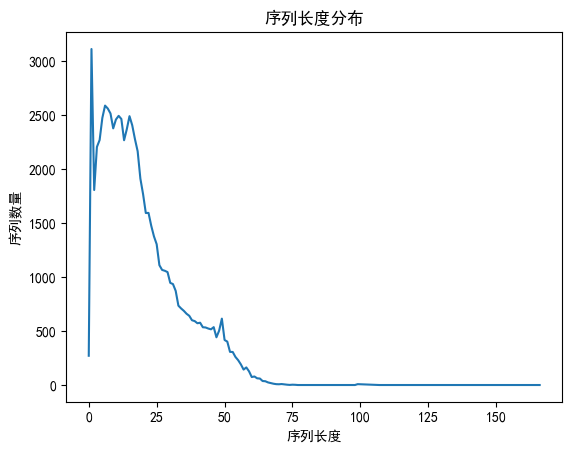

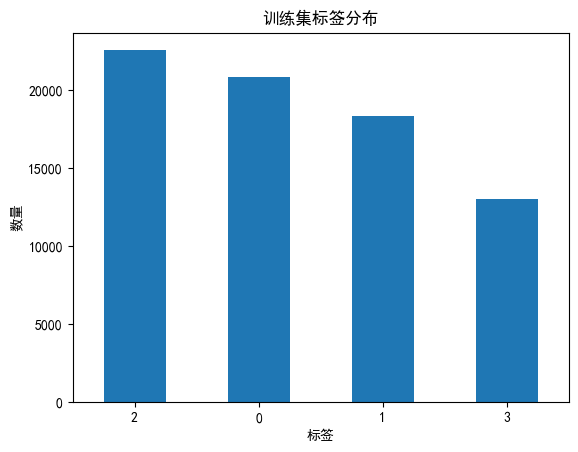

In [25]:
# 长度分布查看
x_train=tok.texts_to_sequences(new_train_data['Tweet content'].to_numpy())
len_ser=pd.Series([len(i) for i in x_train])
plt.plot(len_ser.value_counts().sort_index())
plt.xlabel('序列长度')
plt.ylabel('序列数量')
plt.title('序列长度分布')
plt.show()

# 查看情感类型分布
new_train_data['sentiment'].value_counts().plot(kind='bar')
plt.xticks(rotation=0)
plt.title('训练集标签分布')
plt.xlabel('标签')
plt.ylabel('数量')
plt.show()


### 2.2 整合后的数据导入及处理函数

In [26]:
def load_data(device="cuda:0" if torch.cuda.is_available() else "cpu"):
    # 导入
    headers=["Tweet ID","entity","sentiment","Tweet content"]
    train_data=pd.read_csv('./archive/twitter_training.csv',header=None,names=headers)
    test_data=pd.read_csv('./archive/twitter_validation.csv',header=None,names=headers)

    # 取出有用部分
    new_train_data = train_data.loc[:,['sentiment','Tweet content']].astype(str)
    new_test_data = test_data.loc[:,['sentiment','Tweet content']].astype(str)

    # 标签数值化
    y_train,unique=pd.factorize(new_train_data['sentiment'])
    # y_train=y_train.to_numpy()
    y_test,unique=pd.factorize(new_test_data['sentiment'])
    # y_test=y_test.to_numpy()

    # 分词
    tok=Tokenizer(num_words=100000)
    tok.fit_on_texts(new_train_data['Tweet content'])

    x_train=tok.texts_to_sequences(new_train_data['Tweet content'].to_numpy())
    x_train = sequence.pad_sequences(x_train, maxlen=100)
    
    x_test=tok.texts_to_sequences(new_test_data['Tweet content'].to_numpy())
    x_test = sequence.pad_sequences(x_test, maxlen=100)

    # 转换为 tensor(为了防止后面梯度爆炸这里对数据进行了归一化)
    x_train = torch.tensor(x_train, dtype=torch.long, device=device)
    y_train = torch.tensor(y_train, dtype=torch.float32, device=device).view(-1,1)
    x_test = torch.tensor(x_test, dtype=torch.long, device=device)
    y_test = torch.tensor(y_test, dtype=torch.float32, device=device).view(-1,1)
    # scaler=StandardScaler()
    # x_train=torch.tensor(scaler.fit_transform(x_train), dtype=torch.float32, device=device)
    # x_test=torch.tensor(scaler.fit_transform(x_test), dtype=torch.float32, device=device)
    
    # 查看数据集大小
    print(f'训练集大小: {len(train_data)}')
    print(f'测试集大小: {len(test_data)}')
    
    return x_train,y_train,x_test,y_test,tok

# 数据集
class TwitterDataset(Dataset):
    def __init__(self,data,labels):
        self.data = data
        self.labels=labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        return self.data[idx], self.labels[idx]

class TwitterDataLoader(DataLoader):
    def __iter__(self):
        return BackgroundGenerator(super().__iter__(), max_prefetch=32)

## 3.Embedding部分

In [27]:
# Embedding部分 
class InputEmbeddings(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(InputEmbeddings, self).__init__()
        self.embedding_dim = embedding_dim
        self.embed = nn.Embedding(vocab_size, embedding_dim)
        
    def forward(self, x):
        return self.embed(x) * math.sqrt(self.embedding_dim)

## 4.RNN代码

In [28]:
## LSTM单元
class CustomLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CustomLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # 定义权重矩阵
        self.W_i = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_f = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_c = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_o = nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, x, hidden):
        h_prev, c_prev = hidden

        combined = torch.cat((x, h_prev), dim=1)

        i = torch.sigmoid(self.W_i(combined))
        f = torch.sigmoid(self.W_f(combined))
        g = torch.tanh(self.W_c(combined))
        o = torch.sigmoid(self.W_o(combined))

        c_next = f * c_prev + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next
    

In [29]:
##LSTM代码
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.2):
        super(CustomLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cells = nn.ModuleList([CustomLSTMCell(input_size if i == 0 else hidden_size, hidden_size) for i in range(num_layers)])
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        h = [torch.zeros(batch_size, self.hidden_size, device=x.device) for _ in range(self.num_layers)]
        c = [torch.zeros(batch_size, self.hidden_size, device=x.device) for _ in range(self.num_layers)]

        outputs = []
        for t in range(seq_len):
            x_t = x[:, t, :]
            for i, cell in enumerate(self.cells):
                h[i], c[i] = cell(x_t, (h[i], c[i]))
                x_t = self.dropout(h[i])
            outputs.append(h[-1])

        outputs = torch.stack(outputs, dim=1)
        return outputs, (h, c)

In [30]:
##RNN代码
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_dim, num_layers, output_dim=1, dropout=0.2):
        super(RNNModel, self).__init__()
        
        self.embedding =InputEmbeddings(vocab_size, embed_size)
        self.rnn = CustomLSTM(input_size=embed_size, hidden_size=hidden_dim, num_layers=num_layers, dropout=dropout)

        # 全连接层
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.embedding(src)
        embedded = self.dropout(embedded)

        output, (hidden, cell) = self.rnn(embedded)

        # 使用最后一个隐藏状态
        final_output = self.fc(hidden[-1])

        return final_output.squeeze(1)

In [31]:
# 训练函数
def train_model(model,x,y,optimizer,criterion,batch_size=64,epoches=200,mask=None):

    model.train()
    loss_list=[]
    acc_list=[]
    dataset=TwitterDataset(x,y)
    train_loader=TwitterDataLoader(dataset,batch_size=batch_size,shuffle=True)

    for epoch in range(epoches):
        loss_epoch=0
        # correct=0
        # total=0
        for data,label in train_loader:
            optimizer.zero_grad()
            output = model(data)
            label=label.squeeze(1)
            loss = criterion(output,label)
            
            loss.backward()
            optimizer.step()
            loss_epoch+=loss.item()
            acc_epoch = accuracy_score(label.detach().cpu().numpy(), torch.round(torch.sigmoid(output)).detach().cpu().numpy())
            
        print(f"Epoch {epoch+1} Loss: {loss_epoch/len(train_loader)} Accuracy: {acc_epoch}")
        loss_list.append(loss_epoch/len(train_loader))
        acc_list.append(acc_epoch)
        
        if (epoch%10==0)and epoch!=0: print(f'Epoch {epoch+1} Mean Loss: {np.mean(loss_list[epoch-10:epoch])} Mean Acurracy: {np.mean(acc_list[epoch-10:epoch])}')

    return loss_list,acc_list

# 评估函数
def eval_model(model,x,y,batch_size=64):
    model.eval()

    total=0
    correct=0
    dataset=TwitterDataset(x,y)
    train_loader=TwitterDataLoader(dataset,batch_size=batch_size,shuffle=True)

    with torch.no_grad():
        for data,label in train_loader:
            output = model(data)
            predictions = torch.round(torch.sigmoid(output))
            correct += (torch.round(torch.sigmoid(output)).squeeze() == label).sum().item()
            total+=label.size(0)

    output = model(x)
    label=y.squeeze(1).detach().cpu().numpy()
    pred = torch.round(torch.sigmoid(output)).detach().cpu().numpy()

    # 评价指标计算
    acc=accuracy_score(label,pred)
    pre=precision_score(label,pred,average='weighted')
    f1=f1_score(label,pred,average='weighted')

    print(f"Test Dataset Performance:\nAccuracy : {acc:.4f}\nPrecision : {pre:.4f}\nF1 Score : {f1:.4f}")
    return acc,pre,f1

**可调参数如下:** </br>
|参数|说明|
|----|----|
|seed|随机种子|
|batch_size|batch大小|
|n_heads|多头注意力机制的头数|
|embedding_dim|词嵌入维度|
|learning_rate|学习率|
|hidden_dim|全连接层的隐藏层维度|
|num_layers|encoder的层数|
|dropout|dropout概率|
|epoches|训练轮数|

建议调整:
- batch_size
- n_heads
- embedding_dim
- learning_rate
- hidden_dim
- learning_rate
- num_layers<span style="color:red">（强烈建议 可以加快速度）</span>

In [32]:
# 参数及相关设置
seed = 2025
batch_size = 64
embedding_dim = 100
hidden_dim = 128
learning_rate = 1e-3
num_layers = 3
drop_out = 0.2
epoches = 50

# 随机种子设置
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

# 数据加载与设备设置
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
x_train, y_train, x_test, y_test, tok = load_data(device=device)

vocab_size = len(tok.word_index) + 1

# 模型定义
model = RNNModel(vocab_size=vocab_size, 
                 embed_size=embedding_dim, 
                 hidden_dim=hidden_dim, 
                 num_layers=num_layers, 
                 dropout=drop_out)

if torch.cuda.device_count() > 1:
    print(f"正在使用 {torch.cuda.device_count()} GPU进行运算")
    model = nn.DataParallel(model)
elif torch.cuda.device_count() == 1: 
    print("使用单个GPU进行运算")
else: 
    print("使用CPU进行运算")
model.to(device)

训练集大小: 74682
测试集大小: 1000
使用单个GPU进行运算


RNNModel(
  (embedding): InputEmbeddings(
    (embed): Embedding(33785, 100)
  )
  (rnn): CustomLSTM(
    (cells): ModuleList(
      (0): CustomLSTMCell(
        (W_i): Linear(in_features=228, out_features=128, bias=True)
        (W_f): Linear(in_features=228, out_features=128, bias=True)
        (W_c): Linear(in_features=228, out_features=128, bias=True)
        (W_o): Linear(in_features=228, out_features=128, bias=True)
      )
      (1-2): 2 x CustomLSTMCell(
        (W_i): Linear(in_features=256, out_features=128, bias=True)
        (W_f): Linear(in_features=256, out_features=128, bias=True)
        (W_c): Linear(in_features=256, out_features=128, bias=True)
        (W_o): Linear(in_features=256, out_features=128, bias=True)
      )
    )
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [33]:
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion=nn.CrossEntropyLoss()
loss_list, acc_list=train_model(model,x_train,y_train,optimizer,criterion,epoches=epoches)

Epoch 1 Loss: 360.3583548969965 Accuracy: 0.41379310344827586
Epoch 2 Loss: 355.7397955181053 Accuracy: 0.39655172413793105
Epoch 3 Loss: 353.2023127930943 Accuracy: 0.3275862068965517
Epoch 4 Loss: 351.30696192253527 Accuracy: 0.3793103448275862
Epoch 5 Loss: 349.7729089732035 Accuracy: 0.29310344827586204
Epoch 6 Loss: 348.73266948055993 Accuracy: 0.3448275862068966
Epoch 7 Loss: 347.48810392378124 Accuracy: 0.3620689655172414
Epoch 8 Loss: 346.70599455453436 Accuracy: 0.3103448275862069
Epoch 9 Loss: 345.9793017468293 Accuracy: 0.4827586206896552
Epoch 10 Loss: 345.11028038096816 Accuracy: 0.27586206896551724
Epoch 11 Loss: 344.4525995851074 Accuracy: 0.3620689655172414
Epoch 11 Mean Loss: 350.43966841906075 Mean Acurracy: 0.3586206896551724
Epoch 12 Loss: 343.9124249455861 Accuracy: 0.3275862068965517
Epoch 13 Loss: 343.4114631580918 Accuracy: 0.3275862068965517
Epoch 14 Loss: 342.77107931756524 Accuracy: 0.3103448275862069
Epoch 15 Loss: 342.28389769409495 Accuracy: 0.431034482758

KeyboardInterrupt: 

In [34]:
# 模型评估
eval_model(model,x_test,y_test)

Test Dataset Performance:
Accuracy : 0.2840
Precision : 0.1007
F1 Score : 0.1487


(0.284, 0.10067164179104478, 0.14865013774104682)

In [ ]:
# 模型及结果保存
preds = torch.round(torch.sigmoid(model(x_test)))
preds = preds.cpu().detach().numpy()
preds = np.squeeze(preds)

os.makedirs('./model',exist_ok=True)
os.makedirs('./predoictions',exist_ok=True)
np.save('./predoictions/Transformer_Predictions.npy',preds)
torch.save(model.state_dict(),'./model/Transformer_Model.pth')